Universidad Galileo

Statistical Learning 2

PAPD - Sección V

Sergio José Barrios Martínez

Carnet No. 19012765

# Proyecto Final Curso

## Parte No. 1: Feed Forward Network

Para esta parte se seleccionó un Dataset tomado del **UC Irvine Machine Learning Repository** identificado como **Parkinsons Disease Data Set**.

El dataset está compuesto por un rango de mediciones biomédicas de voz de 31 personas, 23 de ellas con la enfermedad de Parkinson. Cada columna del dataset es una medida de voz particular, y cada fila corresponde a 195 grabaciones de voz de individuos (identificados en la primer columna). El objetivo del proyecto es discriminar entre personas sanas y personas con la enfermedad de Parkinson, entrenando este conjunto de datos para sus etiquetas en la columna STATUS (0 para una persona sana y 1 para una persona con Parkinson).

### Información del Dataset:
- name - ASCII subject name and recording number
- MDVP:Fo(Hz) - Average vocal fundamental frequency
- MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
- MDVP:Flo(Hz) - Minimum vocal fundamental frequency
- MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency
- MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
- NHR,HNR - Two measures of ratio of noise to tonal components in the voice
- status - Health status of the subject (one) - Parkinson's, (zero) - healthy
- RPDE,D2 - Two nonlinear dynamical complexity measures
- DFA - Signal fractal scaling exponent
- spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

Más detalles en el Paper:

*'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. 
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)*

Se entrenará una red neuronal secuencial feedforward con la tarea de realizar **clasificación binaria para la enfermedad de Parkinson**, basados las características biomédicas de grabaciones de voz de un paciente, utilizando una **GPU NVidia GeForceRTX 2060**.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import initializers

import numpy as np
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os

#### Creación de DataFrame

In [2]:
data = pd.read_csv('parkinsons.csv')
data

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


En este dataset, la variable a predecir es **STATUS**, con 1 si el estado de salud del paciente es Parkinson ó 0 si está sano. Se reordenará el dataset para pasar la columna STATUS hacia el final. Adicionalmente, se elimina la columna que identifica al paciente, por no ser de relevancia para el modelo.

In [3]:
## Nombre de Columnas del Dataframe
lista_columnas=data.columns
lista_columnas

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [4]:
# Reordenamiento de Columnas del Dataframe, con la columna Status al final.
data = data[['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE','status']]

# Se elimina el nombre del paciente del Dataset
data = data.drop(['name'], axis=1)

# Se reordena aleatoriamente el Dataset
data = data.sample(frac=1).reset_index(drop=True)
data

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,150.258,154.609,75.349,0.00248,0.00002,0.00105,0.00136,0.00315,0.01131,0.107,...,0.01567,0.00495,26.759,0.296888,0.722356,-6.878393,0.089267,2.004055,0.113942,1
1,126.344,134.231,112.773,0.00448,0.00004,0.00131,0.00169,0.00393,0.02033,0.185,...,0.03429,0.00474,25.030,0.507504,0.760361,-6.689151,0.291954,2.431854,0.105993,0
2,139.173,179.139,76.556,0.00390,0.00003,0.00165,0.00208,0.00496,0.01642,0.154,...,0.02184,0.01041,24.889,0.430166,0.665833,-5.660217,0.254989,2.519422,0.199889,1
3,223.361,263.872,87.638,0.00352,0.00002,0.00169,0.00188,0.00506,0.02536,0.225,...,0.04137,0.01493,20.366,0.566849,0.574282,-5.456811,0.345238,2.840556,0.232861,1
4,153.848,165.738,65.782,0.00840,0.00005,0.00428,0.00450,0.01285,0.03810,0.328,...,0.05000,0.03871,17.536,0.660125,0.704087,-4.095442,0.262564,2.739710,0.365391,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,128.451,150.449,75.632,0.01551,0.00012,0.00905,0.00909,0.02716,0.06170,0.584,...,0.09669,0.11843,15.060,0.639808,0.643327,-4.202730,0.310163,2.638279,0.356881,1
191,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,0.140,...,0.02337,0.00607,24.886,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756,1
192,199.228,209.512,192.091,0.00241,0.00001,0.00134,0.00138,0.00402,0.01015,0.089,...,0.01513,0.00167,30.940,0.432439,0.742055,-7.682587,0.173319,2.103106,0.068501,0
193,198.458,219.290,148.691,0.00376,0.00002,0.00182,0.00215,0.00546,0.03527,0.297,...,0.06165,0.01728,18.702,0.606273,0.661735,-5.585259,0.310746,2.465528,0.209863,1


### Balance del Dataset

In [5]:
data['status'].value_counts()

1    147
0     48
Name: status, dtype: int64

### Preparación de Datos
Se realizaran las siguientes tareas de preparación sobre el conjunto de datos, sin hacer Feature Engineering sobre los mismos (ya que esto se espera lo realice la Red Neuronal):
- Reordenamiento aleatorio (paso realizado con anterioridad con frac=1 en el dataframe)
- Definición de Conjuntos de Entrenamiento y Validación (hold out), con el objetivo de realizar validación cruzada.
- Escalado de Features al rango [0,1]

In [6]:
x_entrenamiento, x_test_valid, y_entrenamiento, y_test_valid= train_test_split(data.values[:,:22], data.values[:,22], test_size=0.20)

Escalado de Datos al rango [0,1]

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_x_entrenamiento = scaler.fit_transform(x_entrenamiento)
scaled_x_test = scaler.fit_transform(x_test_valid)

Verificando funcionalidad de GPU

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Número de GPU's disponibles: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Número de GPU's disponibles:  1


#### Definición de Red Neuronal
Se experimentó con distintas arquitecturas de Red Neuronal Tipo FeedForward. Entre ellas utilizar inicialización con heurística (Xavier Initialization) y Batch Normalization en distintas configuraciones.

Quedando esta arquitectura como la final:
- Capa de Inicialización Aleatoria (Xavier Initialization)
- Capa de Normalización de Batch (BatchNorm)
- Capa de Entrada: 22 nodos (uno por característica)
- Capa Oculta No. 1: 10 nodos, Función de Activación: ReLu.
- Capa de Regularización Dropout: 10% de desconexiones.
- Capa Oculta No. 2: 20 nodos, Función de Activación: ReLu.
- Capa de Regularización Dropout: 10% de desconexiones.
- Capa Oculta No. 3: 10 nodos, Función de Activación: ReLu.
- Capa de Regularización Dropout: 10% de desconexiones.
- Capa de Salida: 1 nodos, Función de Activación: Sigmoid

In [16]:
initializer = tf.keras.initializers.GlorotNormal() # se utiliza Heurística Keras Xavier Initialization (GlorotNormal)
Red_Neuronal = Sequential([
    Dense(units=10, input_dim=22, activation='relu',kernel_initializer=initializer),
    BatchNormalization(axis=-1, # Capa de Batch Normalization
                       momentum=0.99, 
                       epsilon=0.001, 
                       center=True, 
                       scale=True, 
                       beta_initializer='zeros', 
                       gamma_initializer='ones', 
                       moving_mean_initializer='zeros', 
                       moving_variance_initializer='ones', 
                       beta_regularizer=None, 
                       gamma_regularizer=None, 
                       beta_constraint=None, 
                       gamma_constraint=None),
    Dropout(0.1),
    Dense(units=20, activation='relu'),
    Dropout(0.1),
    Dense(units=10, activation='relu'),
    Dropout(0.1),
    Dense(units=1, activation='sigmoid')
])

Red_Neuronal.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                230       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10)                40        
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)               

### Grafo
<img src="./imagenes/grafo.png">

#### Compilación del Modelo
En esta sección se experimentó con optimizadores tipo Adam y SGD. Los hiper-parámetros finales de experimentación fueron:
- Learning Rate de 0.01
- Momentum de 0.1

Se utiliza como función de costo "entropía cruzada" para la clasificación binaria, y como métrica el "accuracy" sobre el set de validación definido con anterioridad con sklearn:

In [17]:
Red_Neuronal.compile(optimizer=SGD(learning_rate=0.01,momentum=0.1), loss='binary_crossentropy', metrics=['accuracy'])
set_validacion = (scaled_x_test, y_test_valid)

#### Parametros de Entrenamiento (Mini Batch Gradient Descent)

In [18]:
parametro_epochs = 2000
parametro_batch_size = 20

### Checkpoints, Deployment y Entrenamiento de la Red Neuronal

Se aprovecha la funcionalidad de Keras para definir **Callbacks** con los siguientes objetivos:
- **EarlyStopping**, para detener el algoritmo al lograr convergencia en la función de costo. En este caso, 100 epochs.
- **ModelCheckpoint**, para almacenar los parámetros de entrenamiento al final de cada epoch. En este caso el criterio para almacenar es la mejor métrica de precisión (accuracy) sobre el conjunto de evaluación (test).
- **TensorBoard**, para evidenciar la experimentación y los criterios de evaluación para elegir el modelo final.

Con el propósito de distinguir entre los modelos, se especifica un **string de configuración** para el nombre del archivo con los siguientes datos:
- Número de Epochs
- Tamaño del Mini-Batch
- Número de Capas del Modelo de Red Neuronal.
- Número de Parámetros Entrenables del Modelo de Red Neuronal

In [19]:
logdir = './logs/Epochs_'+str(parametro_epochs)+'_BS_'+str(parametro_batch_size)+'_Lyrs_'+str(len(Red_Neuronal.layers))+'_Params_'+str(Red_Neuronal.count_params())

if not os.path.exists(logdir):
    os.mkdir(logdir)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=100),
    tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/RedNeuronal.Epoch_{epoch:02d}-Val_Loss_{val_loss:.2f}.h5',
                                          save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch = 100000000)
]

history=Red_Neuronal.fit(
      x=scaled_x_entrenamiento
    , y=y_entrenamiento
    , validation_data=set_validacion
    , batch_size=parametro_batch_size
    , epochs=parametro_epochs
    , callbacks=callbacks
    , verbose=0
)

### Historia del Entrenamiento (Modelo Final)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


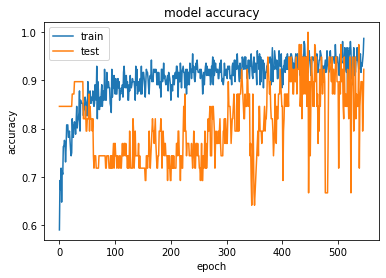

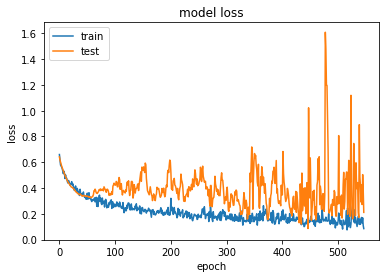

In [20]:
# Historia del Entrenamiento
print(history.history.keys())
# Exactitud (Accuracy)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Costo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### TensorBoard

<img src="./imagenes/accuracy_train.png">

<img src="./imagenes/loss_train.png">

### Checkpoints y Deployment

En este caso, se utiliza el último checkpoint originado por el Callback correspondiente en Keras, denominado **RedNeuronal.Epoch_92-Val_Loss_0.36.h5** (ver carpeta de checkpoints). Adicionalmente, se baja a disco el modelo entrenado.

In [21]:
Red_Neuronal.save_weights('./FFN_Parkinsons.h5')

Este modelo logra el objetivo de tener un accuracy de al menos 85% sobre el set de pruebas (en naranja).

### Predicción y Validación sobre el Conjunto de Pruebas

Se realiza el escalado de las features para el conjunto de pruebas (tal y como se realizó para el conjunto de entrenamiento), con el objetivo de alimentar al modelo y realizar la predicción.

In [22]:
# Escalado al rango [0,1]
test_scaler = MinMaxScaler(feature_range=(0,1))
test_scaled_x_entrenamiento = scaler.fit_transform(x_test_valid)
test_scaled_x_test = scaler.fit_transform(x_test_valid)

In [23]:
# Carga del Modelo desde Disco (deployment)
Parkinsons_model = Red_Neuronal
Parkinsons_model.load_weights('./FFN_Parkinsons.h5')  
y_predicts = Parkinsons_model.predict(test_scaled_x_test, batch_size=32)

In [24]:
# Selección de Umbral para métricas de evaluación
umbral = 0.5
y_predicts[y_predicts>=umbral]=1
y_predicts[y_predicts<umbral]=0

### Métricas de Evaluación
Se implementa con sklearn:
- Matriz de Confusión
- Reporte de Métricas

In [25]:
from sklearn import metrics
matriz_confusion = metrics.confusion_matrix(y_test_valid, y_predicts)

reporte = metrics.classification_report(y_test_valid, y_predicts)

In [26]:
print(reporte)

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         6
         1.0       1.00      0.91      0.95        33

    accuracy                           0.92        39
   macro avg       0.83      0.95      0.88        39
weighted avg       0.95      0.92      0.93        39



### Conclusiones:

Se concluye la experimentación, habiendo probado alrededor de 9 distintas arquitecturas con distintos hiperparámetros, encontrando la siguiente experiencia:
- Al incrementar el número de capas (número de parámetros entrenables) el valor de costo del modelo decrementaba rápidamente, no así el costo en el set de validación. Esto evidenciaba que la arquitectura de red neuronal elegida tendía a sufrir de overfitting con mucha facilidad.
- En general, al aumentar el número de unidades y capas, mayor tendencia a sufrir de overfitting. Para poder combatir esto, se utilizaron capas de **Dropout** llegando hasta un porcentaje de 50%. Esto sin embargo ayudaba hasta cierto punto, pero sin lograr reducir el costo en el set de pruebas, llegando a incrementarse cuando el costo sobre el set de entrenamiento llegaba a ser muy bajo.
- Se experimentó con varias arquitecturas. Entre ellas varias de tipo "piramidal", es decir con el mayor número de unidades en la entrada, para ir reduciendo las unidades hasta llegar a la salida. Esta arquitectura mostró bastante tendencia al overfitting y su accuracy no pasó del 80%.
- Se revisaron algunas arquitecturas alternas. Entre ellas una con tres capas ocultas, con la capa oculta del medio con el mayor número de unidades. Con esta arquitectura se lograron mejores resultados a menor cantidad de epochs.
- El desempeño de la red neuronal sobre el set de pruebas fue bueno, para identificar a personas con Parkinson (accuracy del 92%). Las métricas de recall y F-1 tambien fueron buenas para identificar a enfermos. Dependiendo del umbral, puede mejorarse la estadística para reducir los "falsos-positivos". En este caso se prueba con un umbral "por defecto" de 0.5.

### Anexo (Experimentación)
A continuación se muestran los logs de TensorBoard (incluidos en el repositorio) para evidenciar el proceso de experimentación y selección de modelos.

<img src="./imagenes/accuracy_exp.png">
<img src="./imagenes/loss_exp.png">
